# dAiv AI_Competition[2024]_Basic Baseline for PyTorch

## Import Libraries

In [1]:
from os import path, mkdir, makedirs
import signal

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler

import torchvision
from torchvision import transforms

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

### Check GPU Availability

In [2]:
!nvidia-smi

Thu Aug 29 14:42:16 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:04:00.0 Off |                    0 |
| N/A   40C    P0    34W / 250W |   2357MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   

In [3]:
import os

# ** Please select CUDA DEVICES before training the model **
# Set CUDA_VISIBLE_DEVICES to specify which GPUs to use
os.environ["CUDA_VISIBLE_DEVICES"] = "5, 6"

# Set device to CUDA (which will use the GPUs specified above)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("INFO: Using device -", device)
print("Number of devices currently in use -", torch.cuda.device_count())

INFO: Using device - cuda
Number of devices currently in use - 5


## Load DataSets

In [4]:
from typing import Callable, Optional
from torchvision.datasets.utils import download_and_extract_archive

torchvision.datasets.utils.tqdm = tqdm


class FoodImageDataset(torchvision.datasets.ImageFolder):
    download_url = "https://daiv-cnu.duckdns.org/contest/ai_competition[2024]_basic/dataset/datasets.zip"

    def __init__(self, root: str, force_download: bool = True, train: bool = True, valid: bool = False, transform: Optional[Callable] = None, target_transform: 
                 Optional[Callable] = None):
        self.download(root, force=force_download)

        if train:
            if valid:
                root = path.join(root, "valid")
            else:
                root = path.join(root, "train")
        else:
            root = path.join(root, "test")

        super().__init__(root=root, transform=transform, target_transform=target_transform)

    @classmethod
    def download(cls, root: str, force: bool = False):
        if force or not path.isfile(path.join(root, "datasets.zip")):
            download_and_extract_archive(cls.download_url, download_root=root, extract_root=root, filename="datasets.zip")
            print("INFO: Dataset archive downloaded and extracted.")
        else:
            print("INFO: Dataset archive found in the root directory. Skipping download.")

In [5]:
# Image Resizing and Tensor Conversion
IMG_SIZE = (512, 512)
IMG_NORM = dict(  # ImageNet Normalization
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)

resizer = transforms.Compose([
    transforms.Resize(IMG_SIZE),  # Resize Image
    transforms.ToTensor(),  # Convert Image to Tensor
    transforms.Normalize(**IMG_NORM)  # Normalization
])

In [6]:
DATA_ROOT = path.join(".", "data")

train_dataset = FoodImageDataset(root=DATA_ROOT, force_download=False, train=True, transform=resizer)
valid_dataset = FoodImageDataset(root=DATA_ROOT, force_download=False, valid=True, transform=resizer)
test_dataset = FoodImageDataset(root=DATA_ROOT, force_download=False, train=False, transform=resizer)

print(f"INFO: Dataset loaded successfully. Number of samples - Train({len(train_dataset)}), Valid({len(valid_dataset)}), Test({len(test_dataset)})")

INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset loaded successfully. Number of samples - Train(9880), Valid(3430), Test(3348)


## Data Augmentation if needed

In [7]:
ROTATE_ANGLE = 20
COLOR_TRANSFORM = 0.1

In [8]:
augmenter = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(ROTATE_ANGLE),
    transforms.ColorJitter(
        brightness=COLOR_TRANSFORM, contrast=COLOR_TRANSFORM,
        saturation=COLOR_TRANSFORM, hue=COLOR_TRANSFORM
    ),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0), ratio=(0.75, 1.333)),
    resizer,
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random')
    
])

In [9]:
train_dataset = FoodImageDataset(root=DATA_ROOT, force_download=False, train=True, transform=augmenter)

print(f"INFO: Train dataset has been overridden with augmented state. Number of samples - Train({len(train_dataset)})")

INFO: Dataset archive found in the root directory. Skipping download.
INFO: Train dataset has been overridden with augmented state. Number of samples - Train(9880)


## DataLoader

In [10]:
# Set Batch Size
if torch.cuda.device_count() > 2:
    BATCH_SIZE = 80
elif torch.cuda.device_count() == 2:
    BATCH_SIZE = 32
else:
    BATCH_SIZE = 16

print("INFO: BATCH_SIZE -", BATCH_SIZE)

# CutMix 함수
def cutmix_data(x, y, alpha=1.0):
    indices = torch.randperm(x.size(0))
    shuffled_x = x[indices]
    shuffled_y = y[indices]

    lam = np.clip(np.random.beta(alpha, alpha), 0.3, 0.7)

    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x[:, :, bbx1:bbx2, bby1:bby2] = shuffled_x[:, :, bbx1:bbx2, bby1:bby2]

    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size(-1) * x.size(-2)))

    return x, y, shuffled_y, lam

# MixUp 함수
def mixup_data(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha)

    indices = torch.randperm(x.size(0))
    shuffled_x = x[indices]
    shuffled_y = y[indices]

    mixed_x = lam * x + (1 - lam) * shuffled_x

    y_a, y_b = y, shuffled_y

    return mixed_x, y_a, y_b, lam

# 임의의 바운딩 박스 생성 함수
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

INFO: BATCH_SIZE - 80


In [11]:
import torch
from torch.utils.data import WeightedRandomSampler
from collections import Counter
from multiprocessing import Pool, cpu_count

# 클래스별 샘플 수를 계산하는 함수
def count_class_samples(targets, num_classes):
    class_counts = Counter(targets)
    return [class_counts[i] for i in range(num_classes)]

# 멀티프로세싱을 사용하여 샘플 가중치 계산
def calculate_sample_weights(targets, num_classes):
    with Pool(cpu_count()) as pool:
        # 병렬 처리로 클래스별 샘플 수를 계산
        class_counts = pool.apply(count_class_samples, (targets, num_classes))

    class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
    sample_weights = [class_weights[label] for label in targets]
    return sample_weights

# 데이터셋에 대해 클래스별 샘플 수를 계산하고 가중치 생성
targets = train_dataset.targets  # train_dataset.targets는 클래스 라벨 리스트 또는 텐서라고 가정
num_classes = len(set(targets))  # 클래스 개수
sample_weights = calculate_sample_weights(targets, num_classes)

# WeightedRandomSampler 생성
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

print("INFO: Sample weights and sampler created successfully.")

INFO: Sample weights and sampler created successfully.


In [12]:
# Custom Dataset Loader
class CustomDatasetLoader(DataLoader):
    def __init__(self, *args, use_cutmix=False, use_mixup=False, alpha=1.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.use_cutmix = use_cutmix
        self.use_mixup = use_mixup
        self.alpha = alpha

    def __iter__(self):
        for batch in super().__iter__():
            x, y = batch
            batch_size = x.size(0)

            half = batch_size // 2
            quarter = (batch_size - half) // 2
            remainder = batch_size - (half + quarter + quarter)

            x_transformed = x[:half]
            y_transformed = y[:half]

            x_mixup, y_a_mixup, y_b_mixup, lam_mixup = x[half:half+quarter], y[half:half+quarter], y[half:half+quarter], 1.0
            if self.use_mixup:
                x_mixup, y_a_mixup, y_b_mixup, lam_mixup = mixup_data(x_mixup, y_a_mixup, self.alpha)

            x_cutmix, y_a_cutmix, y_b_cutmix, lam_cutmix = x[half+quarter:], y[half+quarter:], y[half+quarter:], 1.0
            if self.use_cutmix:
                x_cutmix, y_a_cutmix, y_b_cutmix, lam_cutmix = cutmix_data(x_cutmix, y_a_cutmix, self.alpha)

            if remainder > 0:
                x_extra = x[-remainder:]
                y_extra = y[-remainder:]
                x_transformed = torch.cat((x_transformed, x_extra), dim=0)
                y_transformed = torch.cat((y_transformed, y_extra), dim=0)

            x_final = torch.cat((x_transformed, x_mixup, x_cutmix), dim=0)
            y_final = torch.cat((y_transformed, y_a_mixup, y_a_cutmix), dim=0)
            y_final_b = torch.cat((y_transformed, y_b_mixup, y_b_cutmix), dim=0)

            # 최종 배치를 반환, lam 값도 반환하여 사용자가 관리할 수 있게 함
            yield x_final, y_final, y_final_b, lam_mixup, lam_cutmix

In [13]:
# Multi-processing 설정
MULTI_PROCESSING = True

from platform import system
if MULTI_PROCESSING and system() != "Windows":
    import multiprocessing
    cpu_cores = max(1, multiprocessing.cpu_count() // 2)
    print(f"INFO: Number of CPU cores - {cpu_cores}")
else:
    cpu_cores = 0  # 최소 1로 설정하여 비동기 데이터 로딩을 지원
    print("INFO: Using DataLoader with minimum processing.")

INFO: Number of CPU cores - 24


In [14]:
# CustomDatasetLoader 사용 - Sampler 추가
train_loader = CustomDatasetLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,  # WeightedRandomSampler를 사용하여 불균형 데이터 처리
    num_workers=cpu_cores,
    use_cutmix=True,
    use_mixup=True,
    alpha=1.0
)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=cpu_cores)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=cpu_cores)

In [15]:
# Image Visualizer
def imshow(image_list, mean=IMG_NORM['mean'], std=IMG_NORM['std']):
    np_image = image_list.numpy().transpose((1, 2, 0))
    de_norm_image = np_image * std + mean
    plt.figure(figsize=(10, 10))
    plt.imshow(de_norm_image)
    plt.axis('off')
    plt.show()

In [16]:
# 데이터 로더에서 이미지를 가져옴
data = next(iter(train_loader))

if len(data) == 4:
    images, targets = data[:2]
elif len(data) == 5:
    images, targets_a, targets_b, lam_mixup, lam_cutmix = data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


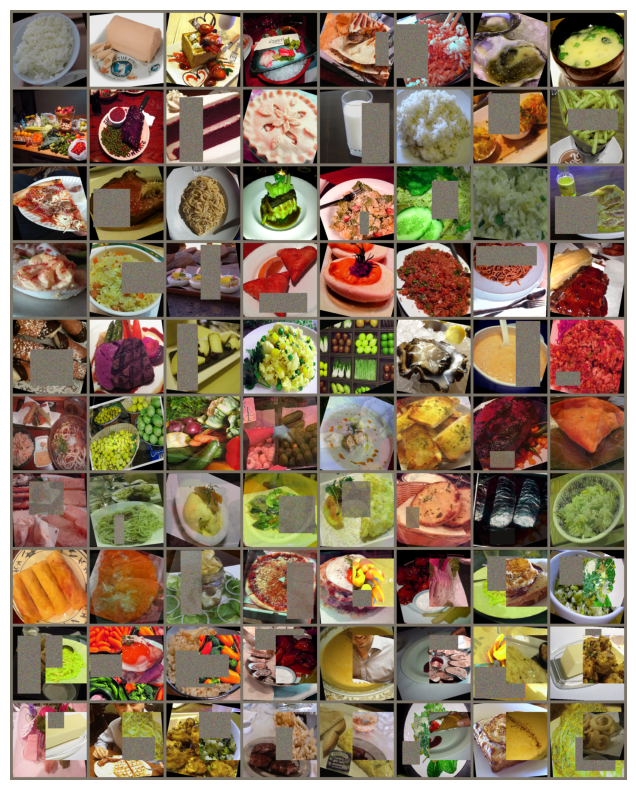

In [17]:
grid_images = torchvision.utils.make_grid(images, nrow=8, padding=20)
imshow(grid_images)

## Define Model

In [18]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x)
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y)
        return x * y.expand_as(x)

class ResNeXtBottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, cardinality=32, base_width=4, reduction=16):
        super(ResNeXtBottleneck, self).__init__()
        width = int(planes * (base_width / 64.)) * cardinality
        # 1x1 Conv
        self.conv1 = nn.Conv2d(in_planes, width, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width)
        # 3x3 Grouped Conv
        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=stride, padding=1, groups=cardinality, bias=False)
        self.bn2 = nn.BatchNorm2d(width)
        # 1x1 Conv
        self.conv3 = nn.Conv2d(width, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)

        # SEBlock 추가
        self.se = SEBlock(planes * self.expansion, reduction)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * self.expansion)
            )

    def forward(self, x):
        out = nn.functional.relu(self.bn1(self.conv1(x)))
        out = nn.functional.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out = self.se(out)  # SEBlock 적용
        out += self.shortcut(x)
        out = nn.functional.relu(out)
        return out


class ResNeXt(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1000, cardinality=32, base_width=4):
        super(ResNeXt, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1, cardinality=cardinality, base_width=base_width)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2, cardinality=cardinality, base_width=base_width)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2, cardinality=cardinality, base_width=base_width)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2, cardinality=cardinality, base_width=base_width)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride, cardinality, base_width):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, cardinality, base_width))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = nn.functional.relu(self.bn1(self.conv1(x)))
        x = nn.functional.max_pool2d(x, kernel_size=3, stride=2, padding=1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def ResNeXt50_32x4d(num_classes=1000):
    return ResNeXt(ResNeXtBottleneck, [3, 4, 6, 3], num_classes=num_classes, cardinality=32, base_width=4)

def ResNeXt101_32x8d(num_classes=1000):
    return ResNeXt(ResNeXtBottleneck, [3, 4, 23, 3], num_classes=num_classes, cardinality=32, base_width=8)

In [19]:
# Initialize Model
model = ResNeXt101_32x8d()
model_id = "ResNeXt101_32x8d"

# 다중 GPU 설정 (DataParallel 사용)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

# 모델을 장치로 이동
model.to(device)

DataParallel(
  (module): ResNeXt(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): ResNeXtBottleneck(
        (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (se): SEBlock(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(256, 16, kernel_size=(1, 1), stride=(1, 1))
          (relu): ReLU()


In [20]:
# LEARNING_RATE = 0.0003  # 학습률을 더 낮추어 더 안정적인 학습을 유도
# WEIGHT_DECAY = 1e-5  # 모델이 더 크므로, Weight Decay를 조금 줄여 과적합 방지
#
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)  # AdamW 옵티마이저 사용
# lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)  # 더 큰 T_max 값으로 학습률 조정 기간 연장

In [21]:
# 학습률을 낮추고 학습 속도를 조정하여 미세 튜닝
LEARNING_RATE = 0.00005  # 매우 낮은 학습률로 파인 튜닝
WEIGHT_DECAY = 1e-6  # Weight Decay를 더욱 줄여 미세한 조정을 가능하게 함

# 기존 CrossEntropyLoss 유지 또는 Label Smoothing 적용
criterion = nn.CrossEntropyLoss()

# AdamW 옵티마이저 사용, 더 낮은 학습률로 조정
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# 학습률 스케줄러 - CosineAnnealingWarmRestarts로 미세 조정
lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)

## Training Loop

In [22]:
# 모델 저장 및 로드 함수 정의
def save_checkpoint(epoch, model, optimizer, loss, PATH):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, PATH)
    print(f" Model saved.")

def load_checkpoint(PATH, model, optimizer):
    if path.isfile(PATH):
        checkpoint = torch.load(PATH)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        loss = checkpoint['loss']
        print(f"체크포인트 '{path.basename(PATH)}'에서 모델 로드 완료 (시작 에포크: {start_epoch})")
        return start_epoch, loss
    else:
        print(f"체크포인트 '{path.basename(PATH)}'를 찾을 수 없습니다. 새로 훈련을 시작합니다.")
        return 0, None

In [23]:
from IPython.display import display
import ipywidgets as widgets

# Interactive Loss Plot Update
def create_plot():
    train_losses = []
    valid_losses = []

    # Enable Interactive Mode
    plt.ion()

    # Loss Plot Setting
    fig, ax = plt.subplots(figsize=(6, 4))
    train_line, = ax.plot(train_losses, label="Train Loss")
    valid_line, = ax.plot(valid_losses, label="Validation Loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title("Cross Entropy Loss")
    ax.legend()

    # Display Plot
    plot = widgets.Output()
    display(plot)

    def update_plot(epoch, train_loss=None, valid_loss=None):
        if train_loss is not None:
            train_losses.append(train_loss)
            train_line.set_ydata(train_losses)
            train_line.set_xdata(range(1, len(train_losses) + 1))

        if valid_loss is not None:
            valid_losses.append(valid_loss)
            valid_line.set_ydata(valid_losses)
            valid_line.set_xdata(range(1, len(valid_losses) + 1))

        ax.relim()
        ax.autoscale_view()
        with plot:
            plot.clear_output(wait=True)
            display(fig)

    return update_plot

In [24]:
def early_stopping(val_loss, best_val_loss, patience_counter, patience, model, epoch, optimizer, checkpoint_path):

    stop_training = False

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        save_checkpoint(epoch, model, optimizer, val_loss, checkpoint_path)  # 최상의 모델 저장
    else:
        patience_counter += 1

    if patience_counter >= patience:
        stop_training = True

    return best_val_loss, patience_counter, stop_training

In [25]:
def process_batch(batch, model, criterion, device):
    if len(batch) == 4:  # CutMix 또는 MixUp이 적용된 경우
        inputs, targets_a, targets_b, lam = batch
        inputs, targets_a, targets_b = inputs.to(device), targets_a.to(device), targets_b.to(device)
        outputs = model(inputs)
        loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
    elif len(batch) == 5:  # CutMix와 MixUp 둘 다 적용된 경우
        inputs, targets_a, targets_b, lam_mixup, lam_cutmix = batch
        inputs, targets_a, targets_b = inputs.to(device), targets_a.to(device), targets_b.to(device)
        outputs = model(inputs)
        loss_mixup = lam_mixup * criterion(outputs, targets_a) + (1 - lam_mixup) * criterion(outputs, targets_b)
        loss_cutmix = lam_cutmix * criterion(outputs, targets_a) + (1 - lam_cutmix) * criterion(outputs, targets_b)
        loss = (loss_mixup + loss_cutmix) / 2
    elif len(batch) == 2:  # CutMix 또는 MixUp이 적용되지 않은 경우
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
    else:
        raise ValueError(f"Unexpected number of elements in batch: {len(batch)}")

    return loss

In [26]:
# Set Epoch Count
num_epochs = 200

/tmp/ipykernel_14308/3692538264.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_14308/330661141.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the

체크포인트 'ResNeXt101_32x8d_checkpoint.pt.tar'에서 모델 로드 완료 (시작 에포크: 85)


Epochs:   0%|          | 0/115 [00:00<?, ?it/s]

Training:   0%|          | 0/124 [00:00<?, ?it/s]

Validation:   0%|          | 0/43 [00:00<?, ?it/s]

Output()

/tmp/ipykernel_14308/3692538264.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # AMP 사용
/shared_hdd/daivcon05/anaconda3/lib/python3.12/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch [86/200], Step [124/124], Loss: 0.804374

/tmp/ipykernel_14308/3692538264.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # AMP 사용


Epoch [86/200], Step [124/124], Loss: 0.804374, Valid Acc: 89.096210%, Valid Loss: 0.363973 Model saved.
Epoch [88/200], Step [9/124], Loss: 0.75099274, Valid Acc: 88.513120%, Valid Loss: 0.377482

KeyboardInterrupt: 

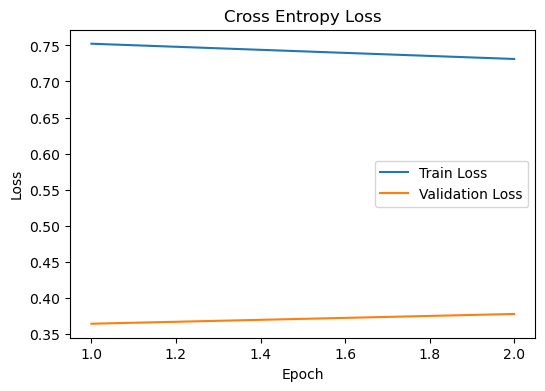

In [27]:
# Mixed Precision Training을 위한 GradScaler 생성
scaler = GradScaler()

# Early Stopping 설정
early_stopping_patience = 20  # 개선이 없을 때 기다릴 에폭 수
best_val_loss = np.inf
patience_counter = 0

# 디렉토리 생성
makedirs('checkpoints', exist_ok=True)
makedirs(path.join('checkpoints', 'early_stopping'), exist_ok=True)

PATH = path.join('checkpoints', f"{model_id}_checkpoint.pt.tar")
early_stopping_PATH = os.path.join('checkpoints', 'early_stopping', f"{model_id}_checkpoint.pt.tar")
save_cycle = 5

# 체크포인트 로드
start_epoch, _ = load_checkpoint(PATH, model, optimizer)

# 훈련 및 검증 루프
train_length, valid_length = map(len, (train_loader, valid_loader))

# 전체 진행 상황 표시를 위한 tqdm 설정
epochs = tqdm(range(start_epoch, num_epochs), desc="Epochs", position=0)
training_bar = tqdm(total=train_length, desc="Training", position=1, leave=True)
validation_bar = tqdm(total=valid_length, desc="Validation", position=2, leave=True)
update = create_plot()  # Create Loss Plot

for epoch in epochs:
    training_bar.reset(total=train_length)
    validation_bar.reset(total=valid_length)

    # Training
    model.train()
    running_train_loss = 0.0
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():  # AMP 사용
            loss = process_batch(batch, model, criterion, device)

        scaler.scale(loss).backward()  # 스케일된 손실로 역전파 수행
        scaler.step(optimizer)  # 스케일러를 사용해 옵티마이저 업데이트
        scaler.update()  # 스케일러 업데이트

        running_train_loss += loss.item()
        training_bar.update(1)
        print(f"\rEpoch [{epoch+1}/{num_epochs}], Step [{i+1}/{train_length}], Loss: {loss.item():.6f}", end="")

    avg_train_loss = running_train_loss / train_length  # 평균 훈련 손실 계산

    val_acc, val_loss = 0, 0

    # Validation
    model.eval()
    with torch.no_grad():
        for inputs, targets in valid_loader:
            with torch.cuda.amp.autocast():  # AMP 사용
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)

                val_loss += criterion(outputs, targets).item() / valid_length
                val_acc += (torch.max(outputs, 1)[1] == targets.data).sum().item()

            validation_bar.update(1)

    val_acc /= len(valid_dataset)
    print(f"\rEpoch [{epoch+1:2}/{num_epochs}], Step [{train_length}/{train_length}], Loss: {loss.item():.6f}, Valid Acc: {val_acc:.6%}, Valid Loss: {val_loss:.6f}", end="\n" if (epoch+1) % save_cycle == 0 or (epoch+1) == num_epochs else "")

    # Update plots with average train and validation losses
    update(epoch + 1, train_loss=avg_train_loss, valid_loss=val_loss)

    # Early Stopping 체크
    best_val_loss, patience_counter, stop_training = early_stopping(
        val_loss, best_val_loss, patience_counter, early_stopping_patience, model, epoch, optimizer, early_stopping_PATH
    )

    if stop_training:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

    # save_cycle마다 모델 저장
    if (epoch + 1) % save_cycle == 0:
        save_checkpoint(epoch, model, optimizer, loss.item(), PATH)

# 마무리 출력
print("Training Completed!")

In [ ]:
if not path.isdir(path.join(".", "models")):
    mkdir(path.join(".", "models"))

# Model Save
save_path = path.join(".", "models", f"{model_id}.pt")
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

# Model Evaluation

In [ ]:
# Load Model
model = ResNeXt101_32x8d()

if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load(path.join(".", "models", f"{model_id}.pt")))
model.to(device)

In [ ]:
results = dict(id=[], label=[])
test_length = len(test_dataset)

model.eval()
with torch.no_grad():
    for inputs, ids in tqdm(test_loader):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        results['id'] += [test_dataset.classes[i] for i in ids]
        results['label'] += [train_dataset.classes[i] for i in preds.cpu().detach().numpy().tolist()]

In [ ]:
# Save Results
results_df = pd.DataFrame(results)

submission_dir = "submissions"
if not path.isdir(submission_dir):
    mkdir(submission_dir)

submit_file_path = path.join(submission_dir, f"{model_id}.csv")
results_df.to_csv(submit_file_path, index=False)
print("File saved to", submit_file_path)

results_df.head()

In [ ]:
# 학습 종료 시 GPU 메모리 해제
torch.cuda.empty_cache()

# 현재 프로세스 PID를 가져와 종료
pid = os.getpid()
os.kill(pid, signal.SIGKILL)